# Load data and python libraries

In [2]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# topic modeling libraries
from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim 

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# progress meter for loops
from tqdm.notebook import tqdm_notebook,tnrange,tqdm

# supporting libraries
import pickle
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',100)

In [3]:
# file location of the cleaned data frame
input_folder = './transition_files/'
output_folder = './output/'

file_name = 'for_topic_modeling.pickle'

In [4]:
# load data
with open(input_folder + file_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    df_data = pickle.load(f)
    
# display first row of the data frame
df_data.tail(1).T

,272241
Hotel_ID,420
average_rating,4.5
hotel_star,3
individual_ratings,5
review_content,"I was in San Antonio for a wedding during the July 4th weekend. Due to an AA meeting, all the ro..."
review_time,Reviewed 23 July 2010
review_title,Great Hotel; new and spacious rooms with a lot of extras
quarter,Q3
day_of_week,Friday
year,2010


In [5]:
#select only positive ratings
print ("Data size before the filter:", len(df_data))
df_data = df_data[df_data['individual_ratings'].isin([4,5])]
print ("Data size after the filter:", len(df_data))

Data size before the filter: 234404
Data size after the filter: 205662


# Create document-term matrix for the LDA model 

In [6]:
# create a vocabulary for the LDA model 
dictionary = corpora.Dictionary(df_data['selected_list_of_lemmas'])

In [7]:
print('Number of texts processed: ', dictionary.num_docs)
print('Number of extracted lemmas: ', len(dictionary.token2id))
print('\nEach text is represented by list of ', len(dictionary.token2id), 
      " tuples: \n\t\t(lemma's index in bag-of-words dictionary, lemma's term frequency)")

Number of texts processed:  205662
Number of extracted lemmas:  16216

Each text is represented by list of  16216  tuples: 
		(lemma's index in bag-of-words dictionary, lemma's term frequency)


In [8]:
# count the number of occurrences of each distinct token in each document
df_data['doc2bow'] = df_data['selected_list_of_lemmas'].apply(lambda x: dictionary.doc2bow(x))
df_data[['selected_list_of_lemmas','doc2bow']].head()

,selected_list_of_lemmas,doc2bow
0,"[personal, remodel, finish]","[(0, 1), (1, 1), (2, 1)]"
1,"[process, renovation, affected, life]","[(3, 1), (4, 1), (5, 1), (6, 1)]"
2,"[strangely, knowledge, impressive, currently, construction, builder, move, poor, rest, outdoor, ...","[(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1),..."
3,"[notch, notch, setting, lake, renovation, obtrusive, investment, lay, class, equipment, spotless...","[(6, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1)]"
4,"[oasis, typical]","[(32, 1), (33, 1)]"


In [9]:
# create document-term matrix for LDA
doc_term_matrix = list(df_data['doc2bow'].values)

# Estimate the number of topics in a corpus (through topic coherence)

To construct LDA topic model we need to find suitable number of topics (parameter of the LDA model).
<br> Below are the steps of using grid search for the parameter value in the range [3;25]

In general, higher the number of topics chosen for the LDA model, more narrow the space of topic words.
For example, instead of covering hotel decor a topic might cover only decor of hotels entrances.

Coherence score is a loose measure of how words in a topic are related to each other.
<br>Higher the score better estimated coherence.

Since the model has probabilistic nature, selecting number of topics is more art than science.
<br>I prefer to test different numbers and see whether clusters of words make sense.

Interactive visualization tool gives you the ability to see and asses the quality of the topic modeling.
In general, it is preferred that topics (bubbles on the pyLDAvis plot) are well spread on the plot area and have little intersections.
You might need to have several iterations before you settle on the number of topics.

In [9]:
# Evaluating performance of LDA parameter "number of topics" through grid search 
# this step will take time (approx. 3 hours on my computer)

LDA = models.LdaMulticore
num_topics_list = np.arange(3,25)

coherenceList_cv = []


# for each number of topics calculate Coherence Score
for num_topics in tqdm(num_topics_list):
    #LDA model
    lda= LDA(corpus=doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
             passes=20,chunksize=4000,random_state=3,workers=2)
    
    #C_v coherence score 
    #(you can find different score performance evaluation here http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=df_data['selected_list_of_lemmas'], dictionary=dictionary, coherence='c_v')
    
    #save model coherence value for the plot
    coherenceList_cv.append(cm_cv.get_coherence())

Text(0.5, 1.05, 'Topic Coherence\n  C_v Score')

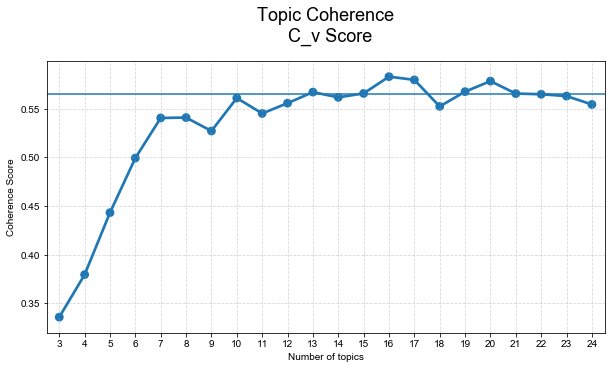

In [10]:
#plot estimated Coherence Score by each topic
df_plot = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence Score':coherenceList_cv})
f, ax = plt.subplots(figsize=(10, 5))
plt.style.use('seaborn-whitegrid')

sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 1.5})
sns.pointplot(x ='Number of topics', y = 'Coherence Score', data=df_plot)

plt.axhline(y=0.565)

ax.grid(True, ls='--', alpha=0.5)
plt.title('Topic Coherence\n  C_v Score', y=1.05, fontsize=18)

Many practitioners choose number of topics that corresponds or close to the smallest number with the highest coherence score when the plot is flattening out or fluctuates around some level.
<br>In our case it is 0.565 and the closest number of topics is 10.

# Define LDA model

In [10]:
# define the model with chosen number of topics
num_topics = 10


LDA = models.LdaMulticore
result_lda_model= LDA(corpus=doc_term_matrix, 
               num_topics=num_topics,
               id2word = dictionary, 
               passes=20,
               chunksize=4000,
               random_state=3)

##### Interactive visualization of topics using pyLDAviz

In [11]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(result_lda_model, doc_term_matrix, dictionary,sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005501  0.100724       1        1  11.514349
1      0.230610 -0.061502       2        1  11.576815
2     -0.174571 -0.016526       3        1  12.151928
3     -0.089379  0.248647       4        1   7.272766
4     -0.134871 -0.067324       5        1  12.378736
5     -0.077090 -0.132111       6        1   9.531321
6      0.039274 -0.058220       7        1   7.477525
7      0.157866  0.156265       8        1   8.664310
8      0.120933 -0.100975       9        1  10.231417
9     -0.067271 -0.068978      10        1   9.200835, topic_info=     Category         Freq      Term        Total  loglift  logprob
1104  Default  5615.000000    resort  5615.000000  30.0000  30.0000
83    Default  5711.000000   wedding  5711.000000  29.0000  29.0000
4748  Default  4279.000000    waffle  4279.000000  28.0000  28.0000
791   Default  3909.000000  activity  3909.000000  27.0000  27.0000
355   Default  3738.000000      base  3738.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
434   Topic10   844.631348    pricey  2943.916016   1.1373  -5.5401
264   Topic10   898.136536     local  4516.292969   0.7708  -5.4787
1243  Topic10   891.080200      road  4999.661621   0.6612  -5.4866
477   Topic10   806.321899   traffic  4642.443848   0.6354  -5.5866
541   Topic10   786.263000      line  3748.758057   0.8240  -5.6118

[751 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
15703      6  0.981782            SAT
8067       2  0.984332          STAFF
7824      10  0.947013     accomadate
229        1  0.127800  accommodating
229        2  0.130981  accommodating
...      ...       ...            ...
569        6  0.016779          young
569        7  0.009061          young
569        8  0.075505          young
569        9  0.656393          young
569       10  0.004027          young

[3595 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

##### spot cheks

In [12]:
def topics(doc2bow, lda_model, n_topic_words=7):
    """
    prints probability score and 7 topic words with their weights in the model.
    input:
        doc2bow       - as list of tuples, each tuple corresponds to number of occurrences of distinct token 
                        in a document 
        lda_model     - trained gensim LDA model
        n_topic_words - as integer, number of topic words to display
        
    """
    print('='*100)
    for index, score in sorted(lda_model[doc2bow], key=lambda tup: -1*tup[1]):
        print("Score: ", round(score, 2)," Topic: ", lda_model.print_topic(index, n_topic_words))

In [13]:
ind = 2

doc2bow = df_data['doc2bow'].iloc[ind]

print( df_data['review_title'].iloc[ind], '\n\n')
print( df_data['review_content'].iloc[ind], '\n\n')
topics(doc2bow, result_lda_model, n_topic_words=5)

Good location & Good views  


Excellent location very close to downtown Austin.Brilliant Views from the hotel.Strangely all staff were new and do not have a great deal of knowledge including concierge.Breakfast is not that impressive.Good rooms , however currently the hotel is under going through construction and we see builders moving around in the lobby etc . Which I think itÕs poor !!Not worth paying $ 1500 a night for all this.The rest the outdoor swimming pool is good and spa is is worth a visit. So mix review and will I stay again is a question I ask my self but hard to decide ...  


Score:  0.43  Topic:  0.016*"surprised" + 0.015*"construction" + 0.014*"conveniently" + 0.012*"loud" + 0.012*"pleasantly"
Score:  0.33  Topic:  0.033*"resort" + 0.021*"activity" + 0.019*"child" + 0.018*"spa" + 0.017*"vacation"
Score:  0.2  Topic:  0.013*"team" + 0.011*"question" + 0.009*"management" + 0.008*"assist" + 0.007*"attention"


# Topic distribution across reviews
which topics are being repetitively mentioned the most in those reviews

In [14]:
# distribution  of topics for each review is presented as 
# list of tuples (topic number, topic probability score) sorted in descending order by topic probability score
# this stem might take a minute seconds
df_data['infered_topics'] = df_data['doc2bow'].apply(lambda d: sorted(result_lda_model[d],key=lambda x:x[1],reverse=True))

print('Topic numbering starts from 0!')
df_data['infered_topics'].head()

Topic numbering starts from 0!


0    [(5, 0.4919236), (1, 0.30803913), (8, 0.025007466), (7, 0.025007209), (0, 0.025005868), (6, 0.02...
1    [(7, 0.3886503), (5, 0.24990387), (1, 0.22096185), (0, 0.02007107), (8, 0.020069668), (3, 0.0200...
2                                                      [(5, 0.4267898), (3, 0.3329011), (1, 0.19650236)]
3                                                                      [(0, 0.7626475), (5, 0.17574275)]
4    [(0, 0.4679978), (6, 0.2652759), (4, 0.033344883), (2, 0.033344105), (5, 0.03334259), (3, 0.0333...
Name: infered_topics, dtype: object

In [15]:
# select top and second topic for each review
# if there is no second topic, use -1

df_data['top_topic'] = df_data['infered_topics'].apply(lambda x: x[0][0])
df_data['second_topic'] = df_data['infered_topics'].apply(lambda x: x[1][0] if len(x)>1 else -1)
df_data[['top_topic', 'second_topic']].head()

,top_topic,second_topic
0,5,1
1,7,5
2,5,3
3,0,5
4,0,6


-1 count means: There is no second topic.
Total number of reviews: 205662


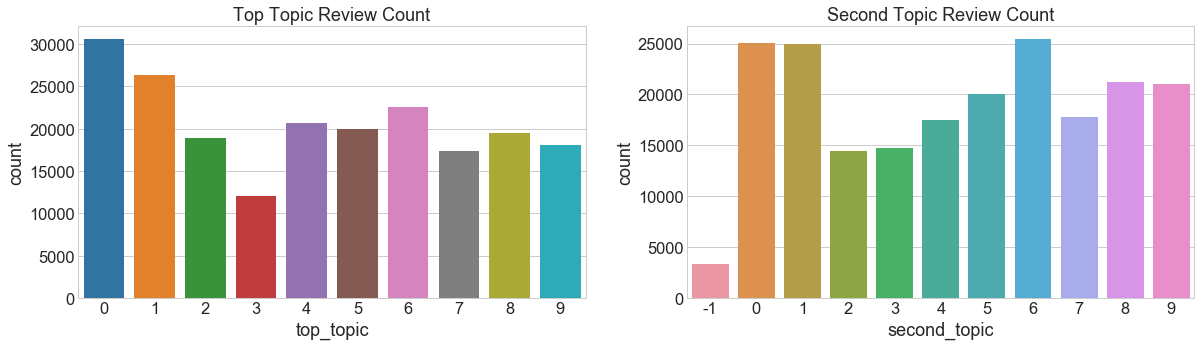

In [16]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1, 2, 1)
ax = sns.countplot(x="top_topic", data=df_data)
ax.set_title('Top Topic Review Count')

ax = fig.add_subplot(1, 2, 2)
ax = sns.countplot(x="second_topic", data=df_data)
ax.set_title('Second Topic Review Count')

print('-1 count means: There is no second topic.')
print('Total number of reviews:', len(df_data))

In [17]:
# get topic ID and corresponding topic words in a data frame and save as .csv file for further analysis

#select number of topic words to extract from the LDA model
number_of_topic_words = 20

dict_topics = dict(result_lda_model.show_topics(num_topics=num_topics,formatted=False,num_words=number_of_topic_words))

df_topics = pd.DataFrame({'topic': list(dict_topics.keys()), 
                          'topic words': list(dict_topics.values())}, index=range(len(dict_topics)))

df_topics['topic'] = df_topics['topic'].apply(lambda x: 'Topic ' + str(x + 1))
df_topics['topic words'] = df_topics['topic words'].apply(lambda x: str(list(dict(x).keys())))


#save topic words in .csv file for further analysis
df_topics.to_csv(output_folder + "topic_words_POSITIVE_reviews.csv")

df_topics

,topic,topic words
0,Topic 1,"['atmosphere', 'decor', 'rooftop', 'overlook', 'fabulous', 'heart', 'favorite', 'notch', 'style'..."
1,Topic 2,"['team', 'question', 'management', 'assist', 'attention', 'answer', 'medical', 'enjoyable', 'hos..."
2,Topic 3,"['waffle', 'fruit', 'living', 'separate', 'sofa', 'sausage', 'refrigerator', 'cereal', 'couch', ..."
3,Topic 4,"['resort', 'activity', 'child', 'spa', 'vacation', 'outdoor', 'movie', 'indoor', 'ground', 'adul..."
4,Topic 5,"['wifi', 'machine', 'window', 'bath', 'outlet', 'mirror', 'self', 'weight', 'design', 'plug', 'e..."
5,Topic 6,"['surprised', 'construction', 'conveniently', 'loud', 'pleasantly', 'game', 'renovation', 'renov..."
6,Topic 7,"['base', 'future', 'graduation', 'accommodation', 'son', 'store', 'exceptional', 'brand', 'highw..."
7,Topic 8,"['wedding', 'anniversary', 'birthday', 'pet', 'daughter', 'cookie', 'dog', 'party', 'delicious',..."
8,Topic 9,"['expectation', 'driver', 'lady', 'exceed', 'young', 'guy', 'clerk', 'man', 'wrong', 'later', 'm..."
9,Topic 10,"['key', 'garage', 'ride', 'taxi', 'bus', 'main', 'card', 'plus', 'entrance', 'negative', 'securi..."


In [18]:
# print all words of selected topic from the df_topics data frame
topic = 'Topic 1'
print(df_topics[df_topics['topic'] == topic]['topic words'].iloc[0])

['atmosphere', 'decor', 'rooftop', 'overlook', 'fabulous', 'heart', 'favorite', 'notch', 'style', 'music', 'venue', 'historic', 'pleasure', 'gorgeous', 'executive', 'art', 'decorate', 'middle', 'beat', 'local']


# Hotel level analysis

Function to process results so that results are readable by hotel to hotel and from one quarter to another in each hotel.

In [19]:
#data preparation for hotel level analysis
df_data['top_topic'] = df_data['top_topic'].apply(str)
df_data['second_topic'] = df_data['second_topic'].apply(str)

#delete observations with missing date
df_data_Ha = df_data[df_data['py_review_date'].isnull() == False]

In [20]:
def get_quarter_topics (hotel_ID):
    """
    Constructs data frame with lists of top and second topics by each year-quarter
    for the hotel with ID = hotel_ID.
    
    input:
        hotel_ID - as integer, hotel ID 
    output:
        data frame with two columns "top_topics" and "second_topics"
        that have lists(sets) of unique topics mentioned in hotel review each quarter
    """
    #get data related to the selected hotel
    df_tmp = df_data_Ha[df_data_Ha['Hotel_ID'] == hotel_ID]

    #sort hotel data by review date in ascending order
    df_tmp = df_tmp.sort_values(by=['py_review_date'])

    #get list of top topics for each quarter
    df_hotel_topics = df_tmp.groupby('year-quarter').agg({'top_topic': lambda x: ' '.join(x),
                                                          'second_topic': lambda x: ' '.join(x)
                                                         })
    #for each year-quarter select only unique topics in the list of mentioned topics
    df_hotel_topics['top_topic'] = df_hotel_topics['top_topic'].apply(lambda x: set(x.split(' ')))
    df_hotel_topics['second_topic'] = df_hotel_topics['second_topic'].apply(lambda x: set(x.split(' ')))
    
    return df_hotel_topics

In [21]:
#select Hotel ID
hotel_ID = 153

#get topics for each quarter-year 
df = get_quarter_topics(hotel_ID)
print('Topics for Hotel ID:', hotel_ID, '\n\tby quarter')
df

Topics for Hotel ID: 153 
	by quarter


,top_topic,second_topic
year-quarter,,
2013Q2,"{4, 1, 5, 9, 3, 6}","{8, 4, 2, 1, 5, 9, 7, 6}"
2013Q3,"{8, 4, 2, 0, 1, 5, 9, 3, 6}","{4, 8, 2, 0, 1, 9, 7, 3, 6}"
2013Q4,"{4, 8, 2, 0, 1, 5, 9, 7, 6}","{4, 8, 2, 0, 1, 5, 9, 3, 6}"
2014Q1,"{8, 2, 0, 1, 5, 9, 3, 6}","{8, 4, 2, 0, 1, 5, 9, 7, 3, 6}"
2014Q2,"{4, 8, 2, 0, 1, 5, 9, 7, 6}","{4, 8, 0, 1, 5, 9, 7, 3, 6}"
2014Q3,"{8, 4, 2, 5, 9, 3, 6}","{4, 8, 2, 0, 1, 5, 9, 7, 3, 6}"
2014Q4,"{8, 2, 0, 1, 5, 9, 7, 6}","{-1, 4, 8, 2, 0, 5, 9, 7, 6}"
2015Q1,"{8, 4, 2, 0, 1, 5, 9, 6}","{4, 8, 2, 0, 1, 5, 9, 7}"
2015Q2,"{4, 2, 0, 1, 5, 9, 3, 6}","{8, 4, 0, 1, 9, 7, 6}"


In [22]:
# save hotel topic table as .csv
df.to_csv(output_folder + str(hotel_ID) + '_positive_topics.csv')

# Topic coherance score
Since gensim LDA model object does not save topic coherence scores with topic IDs in one data object, we need to extract those.

In [23]:
# get topic ID and corresponding topic words
number_of_topic_words = 20

dict_topics = dict(result_lda_model.show_topics(num_topics=num_topics,formatted=False,num_words=number_of_topic_words))

df_topics = pd.DataFrame({'topic': list(dict_topics.keys()), 
                          'topic words': list(dict_topics.values())}, index=range(len(dict_topics)))

df_topics['topic'] = df_topics['topic'].apply(lambda x: 'Topic ' + str(x))
df_topics['topic words'] = df_topics['topic words'].apply(lambda x: str(list(dict(x).keys())))
df_topics

,topic,topic words
0,Topic 0,"['atmosphere', 'decor', 'rooftop', 'overlook', 'fabulous', 'heart', 'favorite', 'notch', 'style'..."
1,Topic 1,"['team', 'question', 'management', 'assist', 'attention', 'answer', 'medical', 'enjoyable', 'hos..."
2,Topic 2,"['waffle', 'fruit', 'living', 'separate', 'sofa', 'sausage', 'refrigerator', 'cereal', 'couch', ..."
3,Topic 3,"['resort', 'activity', 'child', 'spa', 'vacation', 'outdoor', 'movie', 'indoor', 'ground', 'adul..."
4,Topic 4,"['wifi', 'machine', 'window', 'bath', 'outlet', 'mirror', 'self', 'weight', 'design', 'plug', 'e..."
5,Topic 5,"['surprised', 'construction', 'conveniently', 'loud', 'pleasantly', 'game', 'renovation', 'renov..."
6,Topic 6,"['base', 'future', 'graduation', 'accommodation', 'son', 'store', 'exceptional', 'brand', 'highw..."
7,Topic 7,"['wedding', 'anniversary', 'birthday', 'pet', 'daughter', 'cookie', 'dog', 'party', 'delicious',..."
8,Topic 8,"['expectation', 'driver', 'lady', 'exceed', 'young', 'guy', 'clerk', 'man', 'wrong', 'later', 'm..."
9,Topic 9,"['key', 'garage', 'ride', 'taxi', 'bus', 'main', 'card', 'plus', 'entrance', 'negative', 'securi..."


In [24]:
# get topic words and topic average coherence score
list_tmp = result_lda_model.top_topics(doc_term_matrix, dictionary=dictionary, topn=number_of_topic_words, 
                                       coherence='c_v', texts=df_data['selected_list_of_lemmas'])
list_tmp = [(s,wd) for (wd, s) in list_tmp]
dict_scores = dict(list_tmp)
df_scores = pd.DataFrame({'topic coherence score': list(dict_scores.keys()), 
                          'topic words': list(dict_scores.values())}, index=range(len(dict_scores)))
df_scores['topic words'] = df_scores['topic words'].apply(lambda x: str(list(dict(x).values())))
df_scores.head()

,topic coherence score,topic words
0,0.814339,"['waffle', 'fruit', 'living', 'separate', 'sofa', 'sausage', 'refrigerator', 'cereal', 'couch', ..."
1,0.736166,"['resort', 'activity', 'child', 'spa', 'vacation', 'outdoor', 'movie', 'indoor', 'ground', 'adul..."
2,0.610232,"['wifi', 'machine', 'window', 'bath', 'outlet', 'mirror', 'self', 'weight', 'design', 'plug', 'e..."
3,0.529898,"['wedding', 'anniversary', 'birthday', 'pet', 'daughter', 'cookie', 'dog', 'party', 'delicious',..."
4,0.499134,"['expectation', 'driver', 'lady', 'exceed', 'young', 'guy', 'clerk', 'man', 'wrong', 'later', 'm..."


In [25]:
# add topic score to the df_topics to distinguish between human interpretable topics and jargons of statistical analysis
# higher the topic coherence, the topic is more human interpretable. 
print('You can assign names to the topics based on the words related to each topic.')
print('Topic coherence score gives you an idea how easy it is to choose Name to a topic.')
df_topics = df_topics.merge(df_scores, on='topic words')
df_topics.sort_values(by='topic coherence score',ascending=False,inplace=True)
df_topics

You can assign names to the topics based on the words related to each topic.
Topic coherence score gives you an idea how easy it is to choose Name to a topic.


,topic,topic words,topic coherence score
2,Topic 2,"['waffle', 'fruit', 'living', 'separate', 'sofa', 'sausage', 'refrigerator', 'cereal', 'couch', ...",0.814339
3,Topic 3,"['resort', 'activity', 'child', 'spa', 'vacation', 'outdoor', 'movie', 'indoor', 'ground', 'adul...",0.736166
4,Topic 4,"['wifi', 'machine', 'window', 'bath', 'outlet', 'mirror', 'self', 'weight', 'design', 'plug', 'e...",0.610232
7,Topic 7,"['wedding', 'anniversary', 'birthday', 'pet', 'daughter', 'cookie', 'dog', 'party', 'delicious',...",0.529898
8,Topic 8,"['expectation', 'driver', 'lady', 'exceed', 'young', 'guy', 'clerk', 'man', 'wrong', 'later', 'm...",0.499134
1,Topic 1,"['team', 'question', 'management', 'assist', 'attention', 'answer', 'medical', 'enjoyable', 'hos...",0.472500
9,Topic 9,"['key', 'garage', 'ride', 'taxi', 'bus', 'main', 'card', 'plus', 'entrance', 'negative', 'securi...",0.438423
5,Topic 5,"['surprised', 'construction', 'conveniently', 'loud', 'pleasantly', 'game', 'renovation', 'renov...",0.417205
0,Topic 0,"['atmosphere', 'decor', 'rooftop', 'overlook', 'fabulous', 'heart', 'favorite', 'notch', 'style'...",0.411784
6,Topic 6,"['base', 'future', 'graduation', 'accommodation', 'son', 'store', 'exceptional', 'brand', 'highw...",0.298051


In [27]:
# save topics topic table as .csv
df_topics.to_csv(output_folder + 'coherence_scores_positive_topics.csv')